# 📰 Fake News Detection using NLP & Machine Learning

## Project Overview
The rapid spread of misinformation across digital news platforms has made **fake news detection** an important and challenging problem. This project develops a **fully open-source, cost-free fake news detection system** that classifies news articles as *Fake* or *Factual* using only their textual content.

The focus is on building a solution that is **explainable, reproducible, and robust**, relying on well-established NLP techniques rather than paid APIs or large proprietary models.

---

## Problem Statement
Fake news articles are often written to resemble legitimate journalism while subtly differing in:
- language tone and emotional intensity,
- word choice and repetition,
- use of named entities and political framing.

The challenge is to **automatically identify these patterns** and distinguish fake articles from factual ones without access to external verification sources.

---

## Solution Approach
This project combines multiple NLP and machine learning techniques:
- **Linguistic analysis** using Part-of-Speech tagging and Named Entity Recognition  
- **Text preprocessing** with normalization, lemmatization, and stopword removal  
- **Sentiment analysis** using the VADER model  
- **Topic modeling** with Latent Dirichlet Allocation (LDA)  
- **Supervised classification** using TF-IDF features and linear models  

All preprocessing and modeling steps are implemented using **leakage-safe pipelines** with stratified cross-validation.

---

## How the System Works
1. Raw article text is cleaned and normalized  
2. Text is tokenized and lemmatized using spaCy  
3. Features are extracted using TF-IDF weighted unigrams and bigrams  
4. Linear classifiers are trained and tuned via cross-validation  
5. The final model predicts whether an article is *Fake* or *Factual*

---

## Results
The final model achieves **strong and consistent performance** on a held-out test set, with high precision and recall for both classes. The results demonstrate that carefully engineered classical NLP pipelines can effectively detect fake news without relying on expensive or opaque models.

---

## Import statements

Load the Python libraries and constants used throughout the notebook.

### Why we need them
- `pandas`, `matplotlib`, `seaborn`: data handling and plotting for EDA.
- `spacy`, `nltk`: tokenization, lemmatization, POS/NER and token-level preprocessing.
- `vaderSentiment`: fast rule-based sentiment analysis suitable for short text.
- `gensim`: topic modeling (LDA/LSI) and corpus utilities.
- `scikit-learn`: vectorizers, model training, cross-validation and evaluation.
- `joblib`: saving and loading trained pipelines/models.

### Definitions
- **spaCy**: fast industrial NLP library (tokenization, POS, NER, lemmas).
- **VADER**: rule-based sentiment model tuned for social media - quick and interpretable.
- **Gensim LDA/LSI**: unsupervised methods to discover latent topics in a corpus.

(We define RANDOM_STATE for reproducibility.)

In [7]:
# Fixed imports: removed duplicates, added joblib for model save, and warnings filter
import os
import re
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.cli import download as spacy_download

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, LsiModel, TfidfModel
from gensim.models.coherencemodel import CoherenceModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

import joblib

# reproducibility
RANDOM_STATE = 42


## Plot Settings
Set global plotting defaults so all visualizations are consistent.

### Why we need it
- Controls figure size, plot style and default colors so charts are readable and consistent across the notebook.

### Notes
- Use seaborn and matplotlib settings for a nicer default look instead of repeating options on each plot.

In [8]:
# Plotting defaults (kept)
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_colour = "#00bfbf"
sns.set_style("whitegrid")


## Load Data
Read the CSV file into a DataFrame, clean column names, check shape, and show the first rows + data types.

### Why we need it
- Confirm the file exists and columns match expectations.
- Quickly spot null columns, unexpected types, or formatting issues before analysis.

### Key checks
- number of rows/columns, presence of expected columns (title, text, date, fake_or_factual).
- Drop fully-null columns and trim whitespace from column names.

In [10]:
# Load CSV robustly and show basic info
DATA_PATH = "fake_news_data.csv"  # change path if needed
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found. Place the CSV in the working directory or update DATA_PATH.")

data = pd.read_csv(DATA_PATH)

# Basic cleaning: strip column names and drop columns that are fully null
data.columns = data.columns.str.strip()
data = data.dropna(how="all", axis=1)

# Show the top rows and info
print("Rows, cols:", data.shape)
display(data.head(5))
data.info()


Rows, cols: (198, 4)


,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


## Class Distribution Plot
Visualize how many articles are labeled 'Fake' vs 'Factual'.

### Why we need it
- To detect class imbalance (which affects model training/metrics).
- To get an immediate sense of dataset composition.

### Interpretation tip
If classes are imbalanced, use stratified splits and appropriate metrics such as precision/recall or balanced accuracy.

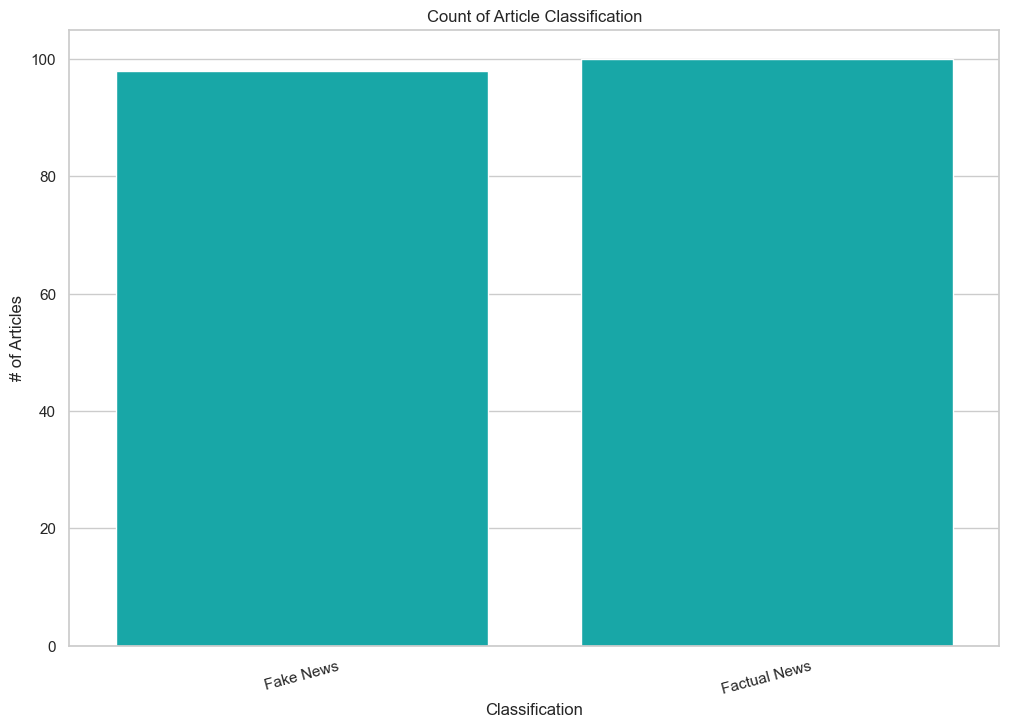

In [11]:
# Check and plot class distribution
if 'fake_or_factual' not in data.columns:
    raise KeyError("Expected column 'fake_or_factual' in dataset")

sns.countplot(x='fake_or_factual', data=data, color=default_plot_colour)
plt.title('Count of Article Classification')
plt.ylabel('# of Articles')
plt.xlabel('Classification')
plt.xticks(rotation=15)
plt.show()


## Ensure NLP Models and Resources are there to use
Download and load required spaCy and NLTK resources if not already installed.

### Why we need it
- spaCy model is needed for tokenization, POS, NER and lemmatization.
- NLTK data (punkt, wordnet, stopwords) is required for tokenization and lemmatization fallback.

### Definitions
- `en_core_web_sm`: spaCy's small English model (fast and lightweight).
- `nltk.download()`: fetches tokenizers and corpora used by NLTK functions.

In [13]:
# Ensure spaCy model present; download programmatically if missing
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("en_core_web_sm not present — downloading now (small model).")
    spacy_download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Ensure NLTK data present
nltk_required = ["punkt", "wordnet", "stopwords", "omw-1.4"]
for pkg in nltk_required:
    try:
        nltk.data.find(f"tokenizers/{pkg}") if pkg == "punkt" else nltk.data.find(f"corpora/{pkg}")
    except LookupError:
        nltk.download(pkg)

# Prepare NLTK objects
lemmatizer = WordNetLemmatizer()
en_stopwords = set(stopwords.words('english'))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saijain\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\saijain\AppData\Roaming\nltk_data...


## Split dataset
Create separate subsets for Fake and Factual articles (keeps original text unchanged).

### Why we need it
- Separate groups let us compare linguistic patterns (POS, entities) between classes.
- We preserve raw text for later, safe preprocessing and modeling.

### Note
This is an exploratory split only — it does not affect model training splits yet.

In [14]:
# Keep raw text available; subset for EDA only (no transformation)
fake_news = data[data["fake_or_factual"].str.lower().str.contains("fake", na=False)].reset_index(drop=True)
fact_news = data[data["fake_or_factual"].str.lower().str.contains("fact", na=False)].reset_index(drop=True)

print("Fake news rows:", fake_news.shape[0])
print("Factual news rows:", fact_news.shape[0])


Fake news rows: 98
Factual news rows: 100


## Create SpaCy docs and extract filtered token tags
Convert article text into SpaCy Doc objects (batch) and extract (token, NER-tag, POS) for meaningful tokens only.

### Why we need it
- Using `nlp.pipe()` is efficient for batch processing.
- Filtering punctuation, whitespace and stopwords yields more informative POS/NER counts for EDA.

### Definitions
- `Doc`: spaCy object representing a parsed document; tokens contain attributes like `lemma_`, `pos_`, `ent_type_`.

In [15]:
# Use nlp.pipe for batch processing and keep docs for later use
# We will create Doc lists but extraction functions will filter punctuation/space tokens
fake_spacydocs = list(nlp.pipe(fake_news['text'].astype(str), disable=[]))
fact_spacydocs = list(nlp.pipe(fact_news['text'].astype(str), disable=[]))

def extract_token_tags_filtered(doc):
    """
    Return list of (token_text, ent_type, pos) for meaningful tokens only
    (filters punctuation, spaces, and stop words).
    """
    out = []
    for t in doc:
        if t.is_space or t.is_punct:
            continue
        # optionally filter stopwords using spaCy token attribute (works without extra stopword lists)
        if t.is_stop:
            continue
        out.append((t.text, t.ent_type_ if t.ent_type_ else "", t.pos_))
    return out

# Build DataFrames with filtered tokens for EDA (this keeps only informative tokens)
fake_tags_list = [pd.DataFrame(extract_token_tags_filtered(doc), columns=["token","ner_tag","pos_tag"]) for doc in fake_spacydocs]
fact_tags_list = [pd.DataFrame(extract_token_tags_filtered(doc), columns=["token","ner_tag","pos_tag"]) for doc in fact_spacydocs]

# Concatenate (if empty lists appear, handle gracefully)
fake_tagsdf = pd.concat(fake_tags_list, ignore_index=True) if fake_tags_list else pd.DataFrame(columns=["token","ner_tag","pos_tag"])
fact_tagsdf = pd.concat(fact_tags_list, ignore_index=True) if fact_tags_list else pd.DataFrame(columns=["token","ner_tag","pos_tag"])

display(fake_tagsdf.head())


,token,ner_tag,pos_tag
0,small,,ADJ
1,problems,,NOUN
2,analogy,,NOUN
3,Susan,PERSON,PROPN
4,Jesus,PERSON,PROPN


## POS Frequency Analysis
Aggregate token counts grouped by POS tag to see which parts-of-speech are most common per class.

### Why we need it
- Exposes stylistic differences (e.g., many proper nouns vs. adjectives) that can inform feature engineering.
- Helps decide whether to emphasize nouns, verbs, or named entities as features.

### Tip
We already filtered stopwords and punctuation so results reflect meaningful content words.

In [31]:
# POS counts for fake and factual
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values('counts', ascending=False)
pos_counts_fact = fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values('counts', ascending=False)

print("Top POS tokens (fake):")
display(pos_counts_fake.head(10))
print("Top POS tokens (fact):")
display(pos_counts_fact.head(10))

# Count how many distinct tokens per POS
print("Fake tokens per POS:")
display(pos_counts_fake.groupby('pos_tag')['token'].nunique().sort_values(ascending=False).head(10))
print("Fact tokens per POS:")
display(pos_counts_fact.groupby('pos_tag')['token'].nunique().sort_values(ascending=False).head(10))


Top POS tokens (fake):


,token,pos_tag,counts
6236,s,PART,324
2008,Trump,PROPN,296
6239,s,VERB,147
6250,said,VERB,144
608,Clinton,PROPN,119
5470,people,NOUN,77
751,Donald,PROPN,75
6798,t,PROPN,74
1482,Obama,PROPN,69
1608,President,PROPN,68


Top POS tokens (fact):


,token,pos_tag,counts
5182,said,VERB,451
1605,Trump,PROPN,229
1622,U.S.,PROPN,177
5174,s,PART,139
1365,Reuters,PROPN,131
1309,President,PROPN,89
3460,government,NOUN,71
838,House,PROPN,71
1638,United,PROPN,69
6132,year,NOUN,64


Fake tokens per POS:


pos_tag
NOUN     2559
VERB     1767
PROPN    1640
ADJ       838
ADV       297
NUM       201
INTJ       17
AUX        14
ADP        13
X          11
Name: token, dtype: int64

Fact tokens per POS:


pos_tag
NOUN     2150
VERB     1499
PROPN    1369
ADJ       709
NUM       191
ADV       180
ADP        12
AUX         7
X           7
PRON        4
Name: token, dtype: int64

## Named Entity Recognition(NER) Counts and Plots
Identify and visualize the most frequent named entities for fake and factual articles separately.

### Why we need it
- Entities (PERSON, ORG, GPE) often differentiate news genres: e.g., fake articles may over-mention specific individuals or conspiracy terms.
- Entity counts can be used as meta-features in a classifier (e.g., number of ORG mentions).

### Note
We plot only non-empty entity tags and use a stable palette for readability.

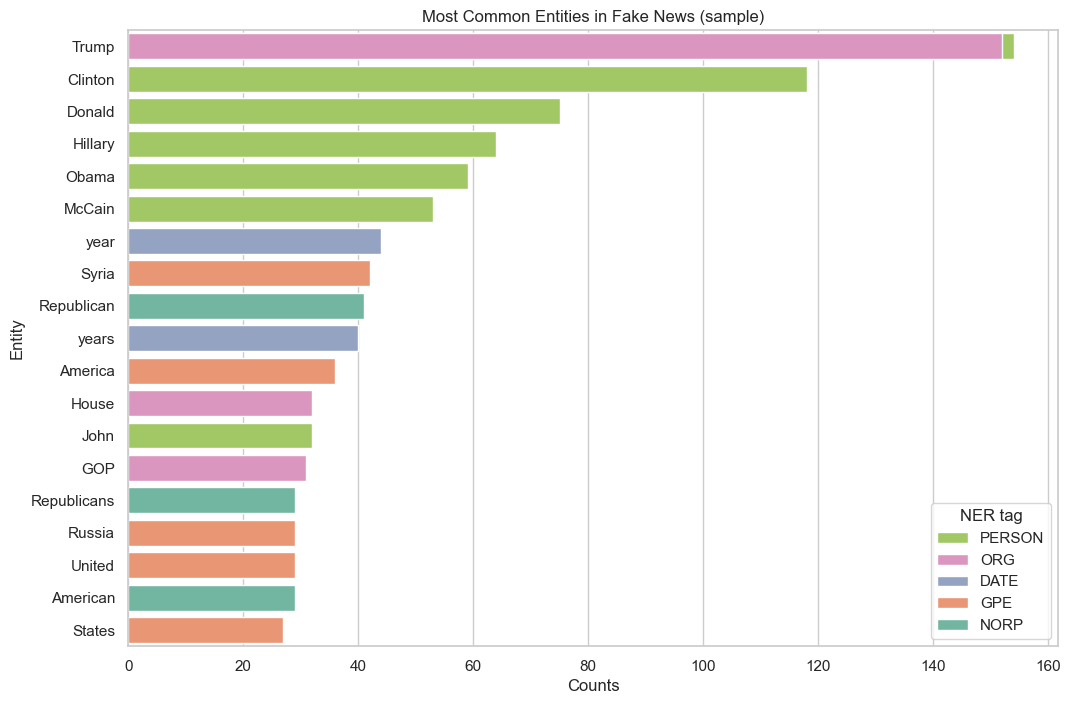

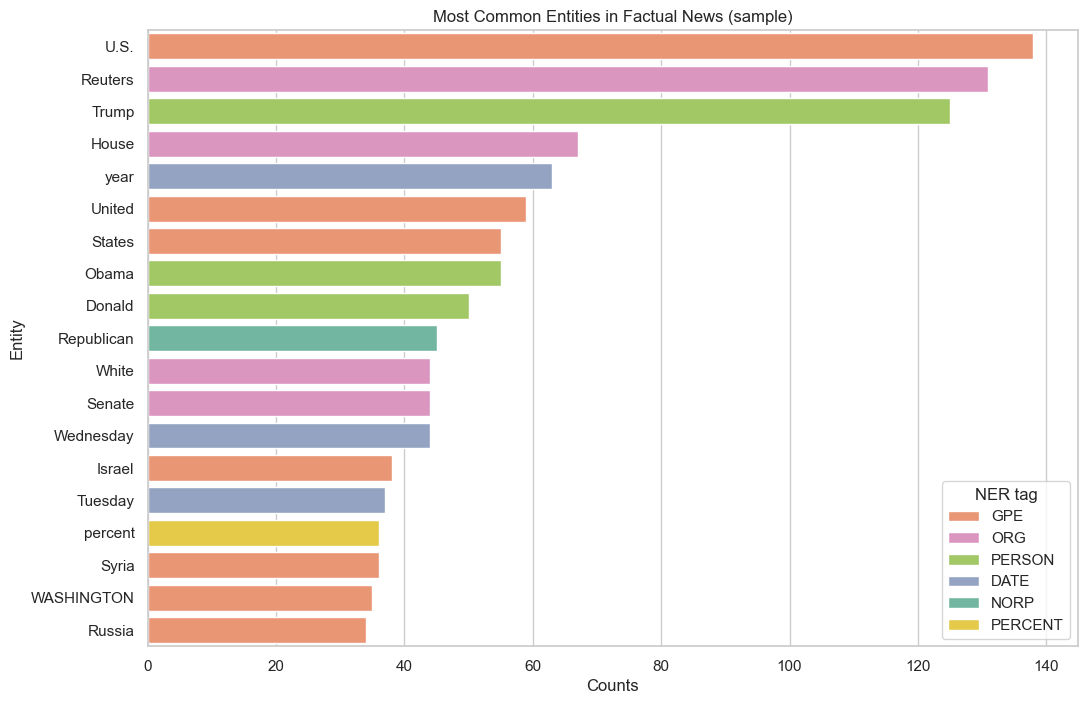

In [32]:
# Get top entities (only non-empty ner_tag)
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False).head(20)

top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False).head(20)

# Create a palette that maps entity types to colors dynamically
unique_entity_types = list(set(top_entities_fake['ner_tag'].unique()).union(set(top_entities_fact['ner_tag'].unique())))
palette = dict(zip(unique_entity_types, sns.color_palette("Set2", n_colors=max(3, len(unique_entity_types))).as_hex()))

# Plot top fake entities
if not top_entities_fake.empty:
    sns.barplot(x='counts', y='token', hue='ner_tag', data=top_entities_fake, palette=palette, dodge=False)
    plt.title('Most Common Entities in Fake News (sample)')
    plt.xlabel('Counts')
    plt.ylabel('Entity')
    plt.legend(title='NER tag')
    plt.show()

# Plot top factual entities
if not top_entities_fact.empty:
    sns.barplot(x='counts', y='token', hue='ner_tag', data=top_entities_fact, palette=palette, dodge=False)
    plt.title('Most Common Entities in Factual News (sample)')
    plt.xlabel('Counts')
    plt.ylabel('Entity')
    plt.legend(title='NER tag')
    plt.show()


### SpaCy based TextPreprocessing and safe normalization
Apply a safe, reproducible preprocessing function that:
- normalizes dateline patterns and U.S. abbreviations,
- lowercases text,
- tokenizes with spaCy,
- removes stopwords/punctuation/numbers,
- lemmatizes tokens, and
- returns a cleaned list of lemmas.

### Why we need it
- Robust preprocessing reduces noise (e.g., "U.S." → "us"), avoids brittle regex mistakes, and yields consistent tokens for vectorizers.
- Using spaCy ensures correct lemmatization and respects POS where applicable.

### Results
Outputs `data['tokens']`: a list of cleaned lemmas for every article.

In [22]:
# Safer preprocessing function using spaCy for tokenization & lemmatization
# - keeps 'us' instead of 'u' for U.S. patterns
# - removes punctuation, stopwords, numbers (optional), short tokens
# - returns list of lemmas

import unicodedata

def safe_normalize_text(text: str):
    if not isinstance(text, str):
        text = str(text or "")
    # Normalize common dateline patterns and abbreviations
    # convert U.S. or U. S. to us before removing punctuation
    text = re.sub(r'\bU\.?S\.?\b', 'us', text, flags=re.IGNORECASE)
    # Normalize unicode and remove weird control chars
    text = unicodedata.normalize("NFKC", text)
    # Remove leading dateline like "WASHINGTON (Reuters) - " more conservatively:
    # remove short uppercase city names followed by parentheses or a hyphen, only if it's likely a dateline
    text = re.sub(r'^[A-Z\s]{2,50}\s*\(.*?\)\s*-\s*', '', text)
    text = re.sub(r'^[A-Z\s]{2,50}\s*-\s*', '', text)
    # Lowercase
    text = text.lower()
    return text

def spacy_preprocess_to_lemmas(text: str, min_len=2, keep_numbers=False):
    text = safe_normalize_text(text)
    doc = nlp(text)
    lemmas = []
    for t in doc:
        if t.is_space or t.is_punct:
            continue
        if t.is_stop:
            continue
        # Optionally drop numeric tokens
        if not keep_numbers and (t.like_num or t.pos_ == "NUM"):
            continue
        lemma = t.lemma_.strip()
        # Basic filter: remove empty and very short tokens
        if not lemma or len(lemma) < min_len:
            continue
        # filter punctuation remnants
        if re.fullmatch(r'^\W+$', lemma):
            continue
        lemmas.append(lemma)
    return lemmas

# Apply to the dataframe into a new column 'tokens' (list of lemmas)
data['tokens'] = data['text'].astype(str).apply(spacy_preprocess_to_lemmas)

# Quick check
display(data[['text','tokens']].head())


,text,tokens
0,There are two small problems with your analogy...,"[small, problem, analogy, susan, jesus, muslim..."
1,Buried in Trump s bonkers interview with New Y...,"[bury, trump, bonker, interview, new, york, ti..."
2,"Women make up over 50 percent of this country,...","[woman, percent, country, grossly, underrepres..."
3,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"[defense, secretary, jim, mattis, say, monday,..."
4,BELFAST (Reuters) - Northern Ireland s politic...,"[northern, ireland, political, party, rapidly,..."


## Unigrams and Bigrams (Post Cleaning)
Compute and display the most frequent unigrams and bigrams using the cleaned tokens.

### Why we need it
- Reveals the most salient words and collocations after preprocessing.
- Used to inform n-gram ranges for vectorizers or to detect obvious leak-prone tokens (e.g., repeated source tags).

### Definitions
- **Bigram**: a sequence of two adjacent tokens (useful for named phrases like "white house").

Top unigrams (post-cleaning):


,token,count
0,say,644
1,trump,594
2,president,272
3,state,207
4,year,182
5,clinton,141
6,obama,126
7,people,125
8,donald,125
9,tell,123


Top bigrams (post-cleaning):


,bigram,count
0,donald trump,113
1,united states,84
2,white house,74
3,president donald,47
4,hillary clinton,40
5,new york,36
6,year old,30
7,supreme court,30
8,official say,26
9,trump administration,25


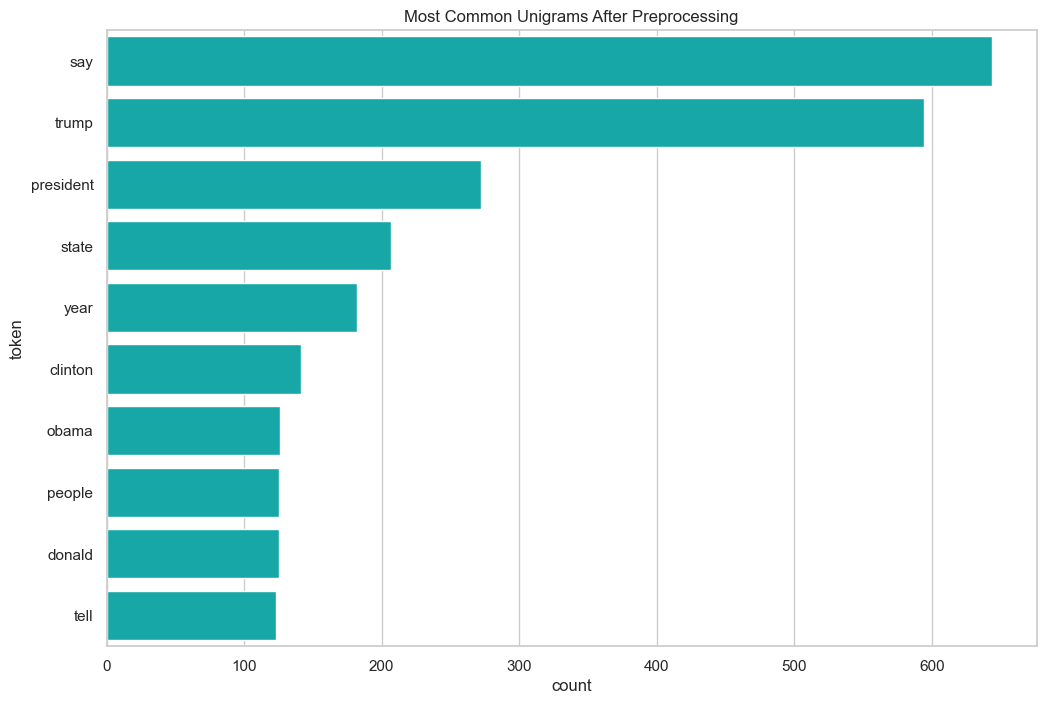

In [23]:
# Flatten token lists to get frequencies
from collections import Counter
all_tokens = [tok for doc in data['tokens'] for tok in doc]
unigram_counts = Counter(all_tokens).most_common(20)
print("Top unigrams (post-cleaning):")
display(pd.DataFrame(unigram_counts, columns=['token','count']))

# Bigram frequencies using gensim Phrases or simple nltk ngrams
from nltk import ngrams
all_bigrams = []
for doc in data['tokens']:
    all_bigrams.extend(list(ngrams(doc, 2)))
bigram_counts = Counter(all_bigrams).most_common(20)
print("Top bigrams (post-cleaning):")
display(pd.DataFrame([(f"{a} {b}", c) for ((a,b), c) in bigram_counts], columns=['bigram','count']))

# Plot top unigrams
top_uni = pd.DataFrame(unigram_counts[:10], columns=['token','count'])
sns.barplot(x='count', y='token', data=top_uni, palette=[default_plot_colour])
plt.title('Most Common Unigrams After Preprocessing')
plt.show()


## Sentiment Analysis (Vader)
Compute VADER compound sentiment scores on both the raw text and the cleaned token-joined text; bucket scores into negative/neutral/positive labels.

### Why we need it
- Provides an emotional/tonal feature that may correlate with fake vs factual content.
- Comparing raw vs cleaned scores helps evaluate preprocessing effects on sentiment.

### Notes & caution
- VADER is rule-based and tuned for social media; it gives quick, interpretable signals but is not as nuanced as contextual models.

Raw sentiment counts:


vader_raw_label
positive    98
negative    93
neutral      7
Name: count, dtype: int64

Clean sentiment counts:


vader_clean_label
positive    107
negative     83
neutral       8
Name: count, dtype: int64

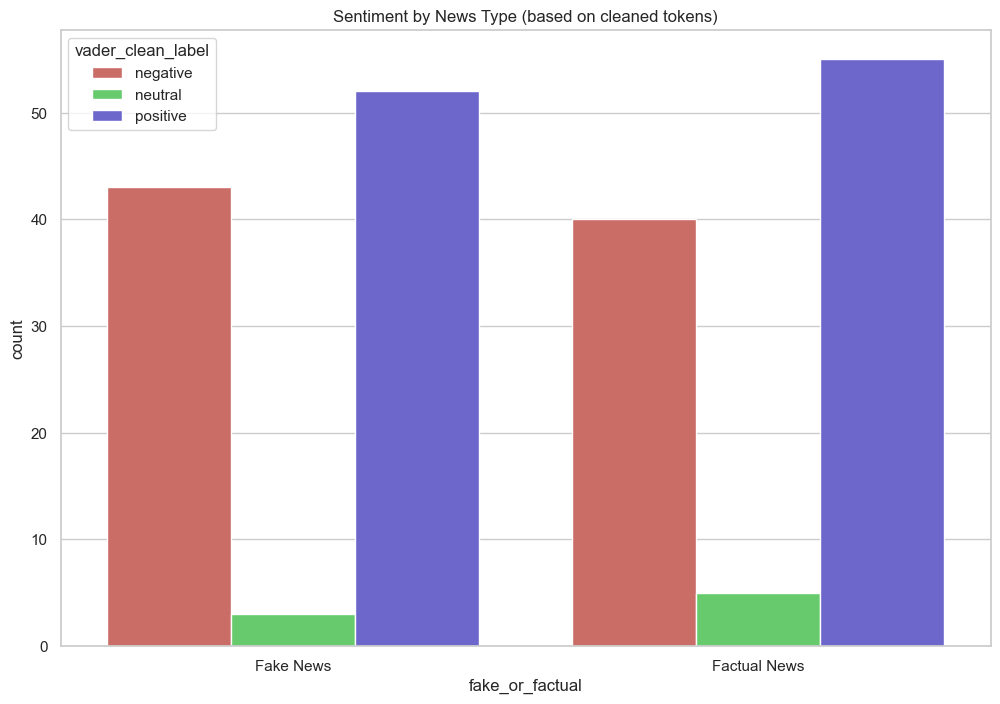

In [24]:
# VADER setup
vader = SentimentIntensityAnalyzer()

# Apply to raw text and also to lemmatized joined text
data['vader_raw_compound'] = data['text'].astype(str).apply(lambda x: vader.polarity_scores(x)['compound'])
data['vader_clean_compound'] = data['tokens'].apply(lambda toks: vader.polarity_scores(" ".join(toks))['compound'])

# Discrete labels using threshold (kept from original but made explicit)
bins = [-1.0, -0.1, 0.1, 1.0]
labels = ['negative', 'neutral', 'positive']
data['vader_raw_label'] = pd.cut(data['vader_raw_compound'], bins=bins, labels=labels)
data['vader_clean_label'] = pd.cut(data['vader_clean_compound'], bins=bins, labels=labels)

# Quick counts and a combined plot
print("Raw sentiment counts:")
display(data['vader_raw_label'].value_counts())
print("Clean sentiment counts:")
display(data['vader_clean_label'].value_counts())

sns.countplot(x='fake_or_factual', hue='vader_clean_label', data=data, palette='hls')
plt.title("Sentiment by News Type (based on cleaned tokens)")
plt.show()


## Topic Modelling with LDA
- Build a Gensim dictionary and corpus (filtered for rare/common tokens).
- Train LDA on fake-news subset over a small range of topics and compute coherence scores.
- Train a final LDA using the chosen topic count and display top words per topic.

### Why we need it
- Topic modeling surfaces themes (e.g., politics, crime, entertainment) that are useful for analysis and for creating topic-based features.
- Filtering extremes (no_below/no_above) improves topic coherence.

### Alternatives
- NMF (TF-IDF + NMF) or BERTopic (embedding-based) often gives more coherent topics but LDA is lightweight and free.

In [25]:
# Build dictionary & corpus for fake-news only (use tokens column)
fake_tokens = data[data['fake_or_factual'].str.lower().str.contains("fake", na=False)]['tokens'].tolist()

# Create Dictionary and filter extremes
dictionary_fake = corpora.Dictionary(fake_tokens)
dictionary_fake.filter_extremes(no_below=3, no_above=0.5, keep_n=5000)  # remove rare and very common tokens

# Create bag-of-words corpus
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_tokens]

# Compute coherence for a small range (lightweight)
coherence_values = []
model_options = {}
min_topics = 2
max_topics = 8  # conservative range for small dataset
for k in range(min_topics, max_topics + 1):
    lda = LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics=k, random_state=RANDOM_STATE, passes=10, chunksize=100)
    cm = CoherenceModel(model=lda, texts=fake_tokens, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append((k, cm.get_coherence()))

# Print coherence scores
print("LDA coherence by number of topics:")
display(pd.DataFrame(coherence_values, columns=['num_topics','coherence']).sort_values('coherence', ascending=False))

# Choose best k (or choose 5 if inconclusive)
best_k = max(coherence_values, key=lambda x: x[1])[0] if coherence_values else 5
print("Chosen num_topics:", best_k)

# Train final LDA with chosen k
lda_model = LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics=best_k, random_state=RANDOM_STATE, passes=15, chunksize=100)
print("LDA Topics:")
for idx, topic in lda_model.print_topics(num_topics=best_k, num_words=8):
    print(f"Topic {idx}: {topic}")


LDA coherence by number of topics:


,num_topics,coherence
2,4,0.317446
3,5,0.300181
5,7,0.299824
4,6,0.299685
1,3,0.299303
0,2,0.299033
6,8,0.278386


Chosen num_topics: 4
LDA Topics:
Topic 0: 0.011*"syria" + 0.011*"obama" + 0.010*"president" + 0.009*"year" + 0.008*"food" + 0.008*"time" + 0.007*"work" + 0.007*"people"
Topic 1: 0.021*"clinton" + 0.012*"state" + 0.011*"hillary" + 0.009*"woman" + 0.009*"email" + 0.007*"campaign" + 0.006*"official" + 0.006*"president"
Topic 2: 0.011*"president" + 0.011*"vote" + 0.008*"donald" + 0.008*"republican" + 0.008*"candidate" + 0.008*"support" + 0.007*"supporter" + 0.007*"woman"
Topic 3: 0.011*"president" + 0.009*"know" + 0.007*"family" + 0.007*"people" + 0.006*"law" + 0.006*"year" + 0.006*"tell" + 0.006*"student"


## Prepare text for classification
Create a model-ready string for each article by joining the cleaned tokens with spaces:
`data['text_for_model'] = " ".join(tokens)`

### Why we need it
- Vectorizers (TF-IDF/Count) expect string documents. Joining tokens preserves chosen preprocessing while respecting token boundaries.
- We do NOT fit vectorizers here — splitting and pipeline will ensure no leakage.

## Train Test Split
- Perform a stratified train/test split (reproducible via RANDOM_STATE).
- Build a scikit-learn Pipeline containing TF-IDF vectorizer and a classifier (LogisticRegression).
- Use GridSearchCV with StratifiedKFold to tune the classifier's regularization hyperparameter.

### Why we need it
- Pipeline prevents leaking test information into preprocessing or vectorization.
- Stratified splits preserve class ratios, important on small datasets.
- Cross-validation gives a robust estimate of model performance and helps tune hyperparameters.

### Notes
- TF-IDF parameters such as `min_df`, `max_df`, and `ngram_range` control which features remain and greatly affect generalization.

In [26]:
# Prepare features as strings (space-joined tokens) — do NOT fit vectorizer on whole dataset
data['text_for_model'] = data['tokens'].apply(lambda toks: " ".join(toks))

X = data['text_for_model']
y = data['fake_or_factual']

# Stratified split, reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

# Build pipeline: TF-IDF (with ngrams) + LogisticRegression (regularized)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=3)),
    ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

# Grid search for regularization C (cheap)
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 5.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV best score (f1_macro):", grid.best_score_)


Train size: 138 Test size: 60
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'clf__C': 5.0}
CV best score (f1_macro): 0.8973551476949698


## Evaluate Model (Confusion Matrix)
Use the best pipeline from GridSearchCV to predict the hold-out test set and report:
- accuracy
- classification report (precision, recall, f1 for each class)
- confusion matrix heatmap

### Why we need it
- The hold-out test set provides an unbiased estimate of real-world performance (if split and preprocessing were correct).
- Confusion matrix reveals which class the model confuses (false positives vs false negatives).

### Tip
Prefer metrics beyond accuracy (precision/recall/F1) for imbalanced or cost-sensitive tasks.

Test accuracy: 0.9166666666666666

Classification report:
              precision    recall  f1-score   support

Factual News       0.96      0.87      0.91        30
   Fake News       0.88      0.97      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



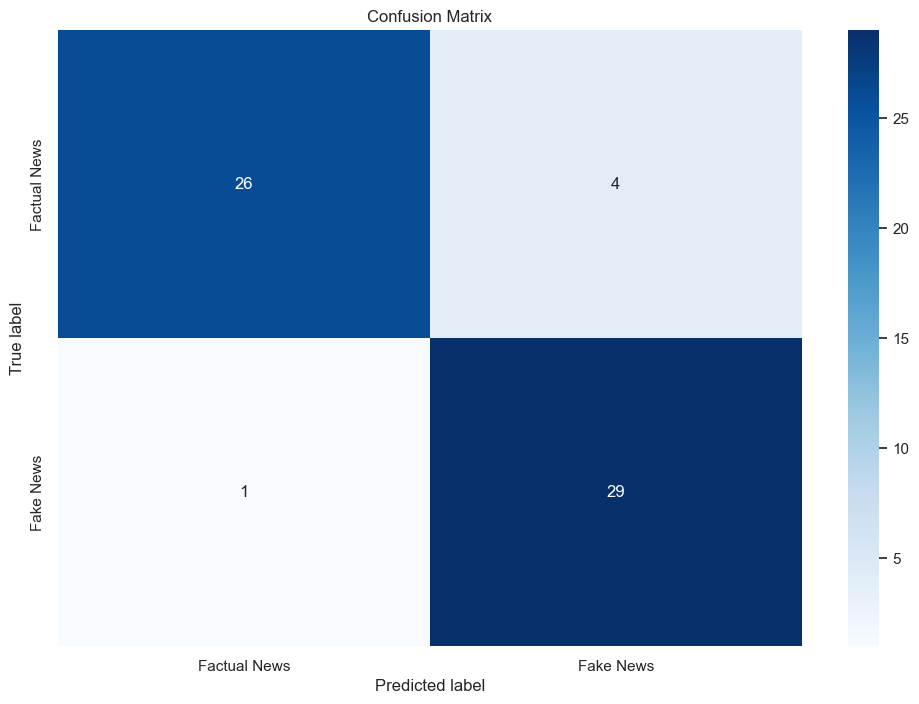

In [27]:
# Predict & evaluate
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
cm_df = pd.DataFrame(cm, index=best_model.classes_, columns=best_model.classes_)
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## Compare with SGDClassifier
- Define a pipeline with an SGDClassifier (fast linear SVM) and compute cross-validated f1_macro scores for both LogisticRegression and SGD pipelines.

### Why we need it
- Compare different linear models to check which generalizes better on cross-validation.
- Cross-validation across the entire dataset gives a sense of performance variance (stability) not captured by a single split.

### Note
- Use the same TF-IDF settings inside each pipeline to ensure fair comparison.

In [35]:
# Compare with linear SVM (SGDClassifier) inside pipeline and quick CV
pipe_sgd = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=3)),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3, random_state=RANDOM_STATE))
])

# Quick cross-validation on full dataset for both models to estimate stability
scores_lr = cross_val_score(grid.best_estimator_, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
scores_sgd = cross_val_score(pipe_sgd, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)

print("Logistic CV f1_macro mean±std:", scores_lr.mean(), scores_lr.std())
print("SGD CV f1_macro mean±std:", scores_sgd.mean(), scores_sgd.std())


Logistic CV f1_macro mean±std: 0.9346527670019326 0.040425004202461805
SGD CV f1_macro mean±std: 0.9291275702058759 0.024734860553926867


## Save the trained pipeline (JobLid)
Persist the trained pipeline (vectorizer + classifier) to disk using joblib.dump.

### Why we need it
- Saving the fitted pipeline makes it trivial to load and predict on new data without re-training.
- A saved pipeline includes preprocessing steps so input strings can be passed directly to `pipeline.predict()`.

### Deployment tip
Store the model alongside reproducible preprocessing code and a README describing the environment and versions.

In [29]:
# Save the best pipeline (vectorizer + classifier) for later use
MODEL_PATH = "best_fake_news_pipeline.joblib"
joblib.dump(best_model, MODEL_PATH)
print("Saved best model pipeline to:", MODEL_PATH)

# Load example
# loaded = joblib.load(MODEL_PATH)
# preds = loaded.predict(["sample cleaned text here"])


Saved best model pipeline to: best_fake_news_pipeline.joblib


## Improvements and next steps
List fast, zero-cost ways to improve the pipeline.

### Suggestions
- Try TF-IDF `ngram_range=(1,2)` and adjust `min_df`/`max_df` to reduce noise.
- Add meta-features (article length, entity counts, sentiment scores) via FeatureUnion/ColumnTransformer.
- Use feature-selection (SelectKBest) or regularization to reduce overfitting.
- Ensemble LogisticRegression and SGDClassifier predictions for reduced variance.
- If feasible, add more labeled data — this typically helps more than heavy hyperparameter tuning.

### Why it matters
Most improvements that increase real-world performance are about better features or more data rather than expensive model changes.